In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
data_dir = "/content/drive/MyDrive/archive (1)/dataset2-master/dataset2-master/images/TRAIN"


In [7]:
data_dir = "/content/drive/MyDrive/archive (1)/dataset-master/dataset2-master/images/TRAIN"

In [9]:
import os

print(os.listdir(data_dir))


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/archive (1)/dataset-master/dataset2-master/images/TRAIN'

In [10]:
data_dir = "/content/drive/MyDrive/archive (1)/dataset2-master/dataset2-master/images"

In [11]:
import os

print(os.listdir(data_dir))

['TRAIN', 'TEST_SIMPLE', 'TEST']


In [12]:
data_dir = "/content/drive/MyDrive/archive (1)/dataset2-master/dataset2-master/images/TRAIN"


In [13]:
import os

print(os.listdir(data_dir))

['MONOCYTE', 'EOSINOPHIL', 'NEUTROPHIL', 'LYMPHOCYTE']


In [14]:
import pandas as pd

filepaths = []
labels = []

class_labels = os.listdir(data_dir)

for label in class_labels:
    class_path = os.path.join(data_dir, label)

    for file in os.listdir(class_path):
        if file.endswith(('.jpg', '.jpeg', '.png')):
            filepaths.append(os.path.join(class_path, file))
            labels.append(label)

bloodCell_df = pd.DataFrame({
    "filepath": filepaths,
    "label": labels
})

bloodCell_df = bloodCell_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Total Images:", len(bloodCell_df))
bloodCell_df['label'].value_counts()


Total Images: 9971


,count
label,
EOSINOPHIL,2511
NEUTROPHIL,2499
LYMPHOCYTE,2483
MONOCYTE,2478


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [17]:
img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 7979 images belonging to 4 classes.
Found 1992 images belonging to 4 classes.


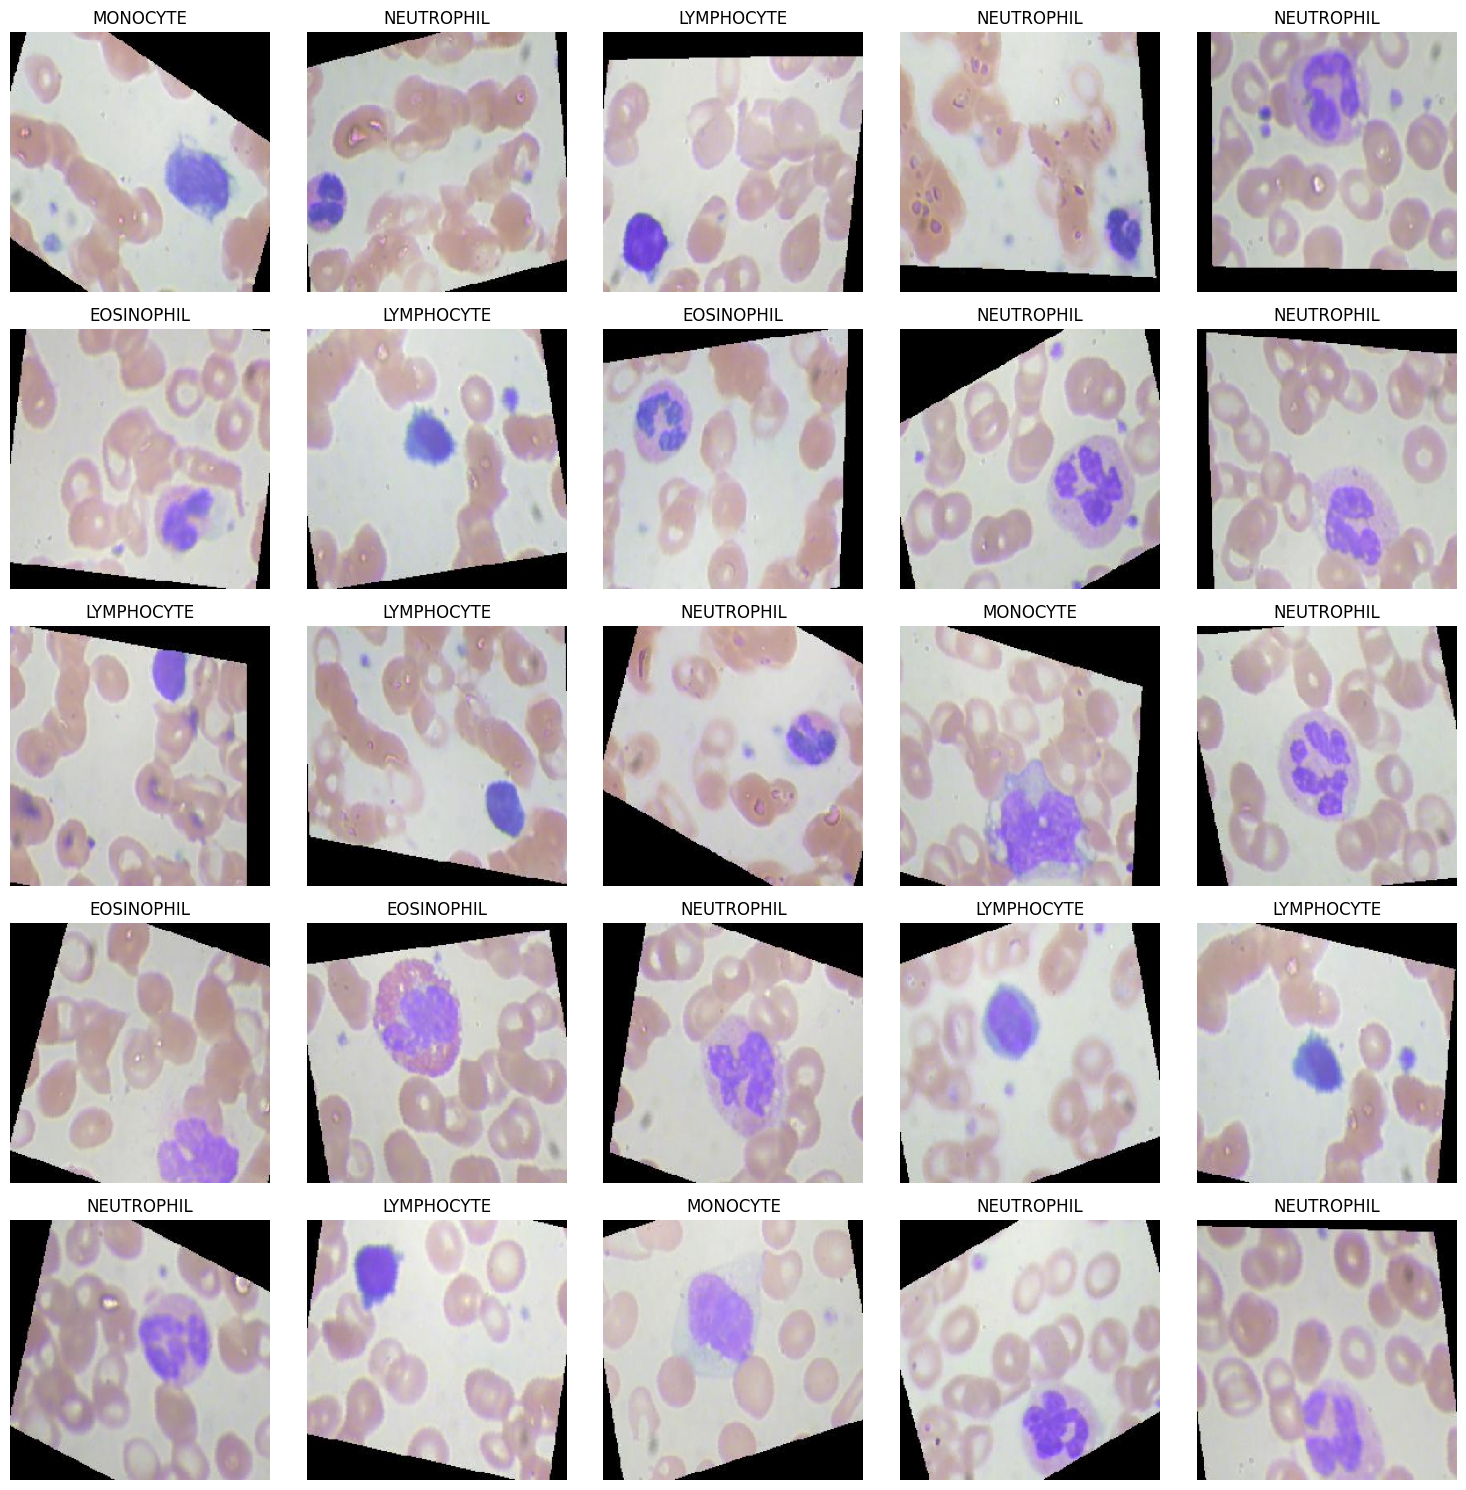

In [18]:
def show_images(generator):
    images, labels = next(generator)
    class_names = list(generator.class_indices.keys())

    plt.figure(figsize=(15,15))
    for i in range(25):
        plt.subplot(5,5,i+1)
        img = (images[i] + 1) / 2
        plt.imshow(img)
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images(train_gen)


In [19]:
base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [20]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2015s 8s/step - accuracy: 0.4143 - loss: 1.3580 - val_accuracy: 0.6401 - val_loss: 0.8467
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.6339 - loss: 0.8780 - val_accuracy: 0.7445 - val_loss: 0.6860
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.6989 - loss: 0.7409 - val_accuracy: 0.7590 - val_loss: 0.6476
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.7298 - loss: 0.6865 - val_accuracy: 0.7882 - val_loss: 0.5925
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.7385 - loss: 0.6503 - val_accuracy: 0.8027 - val_loss: 0.5534
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.7510 - loss: 0.6289 - val_accuracy: 0.8092 - val_loss: 0.5325
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 281s 1s/step - accuracy: 0.7689 - loss: 0.5875 - val_accuracy: 0.7922 - val_loss: 0.5384
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.7592 - loss: 0.5984 - val_acc

In [21]:
loss, accuracy = model.evaluate(val_gen)
print("Validation Accuracy:", accuracy)


63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 886ms/step - accuracy: 0.8207 - loss: 0.4984
Validation Accuracy: 0.8212851285934448


63/63 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step


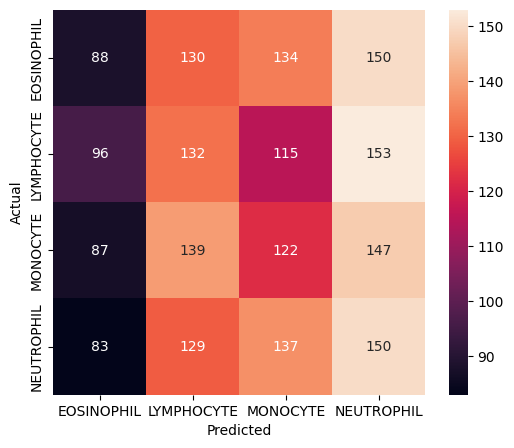

              precision    recall  f1-score   support

           0       0.25      0.18      0.21       502
           1       0.25      0.27      0.26       496
           2       0.24      0.25      0.24       495
           3       0.25      0.30      0.27       499

    accuracy                           0.25      1992
   macro avg       0.25      0.25      0.24      1992
weighted avg       0.25      0.25      0.24      1992



In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

val_gen.reset()
preds = model.predict(val_gen)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=val_gen.class_indices.keys(),
            yticklabels=val_gen.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_true, y_pred))


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 7979 images belonging to 4 classes.
Found 1992 images belonging to 4 classes.


In [24]:
from sklearn.model_selection import train_test_split

# First split: Train (70%) and Temp (30%)
train_df, temp_df = train_test_split(
    bloodCell_df,
    test_size=0.3,
    random_state=42,
    stratify=bloodCell_df['label']
)

# Second split: Validation (15%) and Test (15%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['label']
)

print("Train:", train_df.shape)
print("Validation:", val_df.shape)
print("Test:", test_df.shape)


Train: (6979, 2)
Validation: (1496, 2)
Test: (1496, 2)


In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

img_size = (224, 224)
batch_size = 32

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = image_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=img_size,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True
)

val_gen = image_gen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="label",
    target_size=img_size,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

test_gen = image_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=img_size,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)


Found 6979 validated image filenames belonging to 4 classes.
Found 1496 validated image filenames belonging to 4 classes.
Found 1496 validated image filenames belonging to 4 classes.


In [26]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [27]:
test_loss, test_accuracy = model.evaluate(test_gen)
print("Test Accuracy:", test_accuracy)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 49s 992ms/step - accuracy: 0.2575 - loss: 1.6535
Test Accuracy: 0.2506684362888336


In [28]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load Pretrained MobileNetV2
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [29]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "blood_cell.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)


In [31]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train = datagen.flow_from_directory(
    '/content/drive/MyDrive/archive (1)',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val = datagen.flow_from_directory(
    '/content/drive/MyDrive/archive (1)',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 10317 images belonging to 2 classes.
Found 2578 images belonging to 2 classes.


In [34]:
print(train.num_classes)
print(train.class_indices)


2
{'dataset-master': 0, 'dataset2-master': 1}


In [35]:
!ls "/content/drive/MyDrive/archive (1)"


dataset2-master  dataset-master


In [36]:
!ls "/content/drive/MyDrive/archive (1)/dataset-master"


dataset-master


In [38]:
!ls "/content/drive/MyDrive"


'10 marks sheet.pdf'
'Aadhar card.pdf'
'Adaptive Night–Time Object Detection for Road Safety Using Vision Transformers (1).docx'
'Adaptive Night–Time Object Detection for Road Safety Using Vision Transformers (2).docx'
'Adaptive Night–Time Object Detection for Road Safety Using Vision Transformers.docx'
'Adaptive_Night–Time_Object_Detection_for_Road_Safety_Using_Vision_Transformers_final_document[1].docx'
'Adaptive Night–Time Object Detection for Road Safety Using Vision Transformers final document.docx'
'Advertisement for Website Group C.doc -_copy.pdf'
'archive (1)'
'Balaji Pan (1).pdf'
'Balaji Pan.pdf'
'Blood Cell.h5'
 Classroom
'Colab Notebooks'
'Completion Certificate _ SkillsBuild Balaji.pdf'
 CopyRight.docx
'DELTAX RESUME.pdf'
'ICAAAI-2025-127  Copy Right form.pdf'
'ICAAAI-2025-127 Payment Receipt (1).pdf'
'ICAAAI-2025-127 Payment Receipt.pdf'
 ICAAAI-2025-127.pptx
 IMG-20251213-WA0010.jpg
'Job Resume (1).pdf'
'Job Resume.pdf'
 kaggle.json
'Plagaisim Report  of Adaptive NightTim

In [39]:
!ls "/content/drive/MyDrive/archive (1)"


dataset2-master  dataset-master


In [40]:
!ls "/content/drive/MyDrive/archive (1)/dataset-master"


dataset-master


In [41]:
!ls "/content/drive/MyDrive/archive (1)/dataset-master/dataset-master"


Annotations  JPEGImages  labels.csv


In [42]:
import pandas as pd

csv_path = "/content/drive/MyDrive/archive (1)/dataset-master/dataset-master/labels.csv"

df = pd.read_csv(csv_path)
df.head()


,Unnamed: 0,Image,Category
0,NaN,0,NEUTROPHIL
1,NaN,1,NEUTROPHIL
2,NaN,2,NEUTROPHIL
3,NaN,3,NEUTROPHIL
4,NaN,4,NEUTROPHIL


In [44]:
df.columns


Index(['Unnamed: 0', 'Image', 'Category'], dtype='object')

In [46]:
image_folder = "/content/drive/MyDrive/archive (1)/dataset-master/dataset-master/JPEGImages/"

df["filepath"] = image_folder + df["Image"].astype(str)

df.head()


,Unnamed: 0,Image,Category,filepath
0,NaN,0,NEUTROPHIL,/content/drive/MyDrive/archive (1)/dataset-mas...
1,NaN,1,NEUTROPHIL,/content/drive/MyDrive/archive (1)/dataset-mas...
2,NaN,2,NEUTROPHIL,/content/drive/MyDrive/archive (1)/dataset-mas...
3,NaN,3,NEUTROPHIL,/content/drive/MyDrive/archive (1)/dataset-mas...
4,NaN,4,NEUTROPHIL,/content/drive/MyDrive/archive (1)/dataset-mas...


In [47]:
import os
print(os.listdir(image_folder)[:5])


['BloodImage_00044.jpg', 'BloodImage_00120.jpg', 'BloodImage_00008.jpg', 'BloodImage_00066.jpg', 'BloodImage_00107.jpg']


In [48]:
df["filepath"] = image_folder + df["Image"].astype(str) + ".jpg"


In [49]:
import os
print(os.path.exists(df["filepath"].iloc[0]))


False


In [50]:
import os
print(os.listdir(image_folder)[:10])


['BloodImage_00044.jpg', 'BloodImage_00120.jpg', 'BloodImage_00008.jpg', 'BloodImage_00066.jpg', 'BloodImage_00107.jpg', 'BloodImage_00003.jpg', 'BloodImage_00070.jpg', 'BloodImage_00144.jpg', 'BloodImage_00154.jpg', 'BloodImage_00015.jpg']


In [51]:
print(df["Image"].head())


0    0
1    1
2    2
3    3
4    4
Name: Image, dtype: int64


In [52]:
print(os.listdir(image_folder)[:10])


['BloodImage_00044.jpg', 'BloodImage_00120.jpg', 'BloodImage_00008.jpg', 'BloodImage_00066.jpg', 'BloodImage_00107.jpg', 'BloodImage_00003.jpg', 'BloodImage_00070.jpg', 'BloodImage_00144.jpg', 'BloodImage_00154.jpg', 'BloodImage_00015.jpg']


In [53]:
df["filepath"] = image_folder + df["Image"].astype(str) + ".jpg"


In [54]:
import os
print(os.path.exists(df["filepath"].iloc[0]))


False


In [55]:
import os

print("Folder sample:")
print(os.listdir(image_folder)[:10])

print("\nCSV sample:")
print(df["Image"].head())


Folder sample:
['BloodImage_00044.jpg', 'BloodImage_00120.jpg', 'BloodImage_00008.jpg', 'BloodImage_00066.jpg', 'BloodImage_00107.jpg', 'BloodImage_00003.jpg', 'BloodImage_00070.jpg', 'BloodImage_00144.jpg', 'BloodImage_00154.jpg', 'BloodImage_00015.jpg']

CSV sample:
0    0
1    1
2    2
3    3
4    4
Name: Image, dtype: int64


In [56]:
image_folder = "/content/drive/MyDrive/archive (1)/dataset-master/dataset-master/JPEGImages/"

df["filepath"] = (
    image_folder
    + "BloodImage_"
    + df["Image"].astype(str).str.zfill(5)
    + ".jpg"
)


In [57]:
import os
print(df["filepath"].iloc[0])
print(os.path.exists(df["filepath"].iloc[0]))


/content/drive/MyDrive/archive (1)/dataset-master/dataset-master/JPEGImages/BloodImage_00000.jpg
True


In [58]:
print(df["Category"].unique())
print("Total classes:", df["Category"].nunique())


['NEUTROPHIL' 'BASOPHIL' 'EOSINOPHIL' 'NEUTROPHIL, EOSINOPHIL' 'MONOCYTE'
 'LYMPHOCYTE' nan 'NEUTROPHIL,NEUTROPHIL' 'NEUTROPHIL,BASOPHIL'
 'NEUTROPHIL, MONOCYTE' 'EOSINOPHIL,EOSINOPHIL' 'NEUTROPHIL, NEUTROPHIL'
 'EOSINOPHIL, LYMPHOCYTE' 'EOSINOPHIL, EOSINOPHIL' 'MONOCYTE, LYMPHOCYTE'
 'LYMPHOCYTE, LYMPHOCYTE' 'NEUTROPHIL,EOSINOPHIL' 'NEUTROPHIL, LYMPHOCYTE']
Total classes: 17


In [60]:
print(df["Category"].isna().sum())


44


In [61]:
df = df.dropna(subset=["Category"]).reset_index(drop=True)


In [62]:
print("Remaining NaNs:", df["Category"].isna().sum())
print("Total samples:", len(df))
print(df["Category"].value_counts())


Remaining NaNs: 0
Total samples: 367
Category
NEUTROPHIL                207
EOSINOPHIL                 88
LYMPHOCYTE                 33
MONOCYTE                   21
BASOPHIL                    3
NEUTROPHIL, NEUTROPHIL      3
NEUTROPHIL, EOSINOPHIL      2
NEUTROPHIL,BASOPHIL         1
NEUTROPHIL,NEUTROPHIL       1
NEUTROPHIL, MONOCYTE        1
EOSINOPHIL,EOSINOPHIL       1
EOSINOPHIL, LYMPHOCYTE      1
EOSINOPHIL, EOSINOPHIL      1
MONOCYTE, LYMPHOCYTE        1
LYMPHOCYTE, LYMPHOCYTE      1
NEUTROPHIL,EOSINOPHIL       1
NEUTROPHIL, LYMPHOCYTE      1
Name: count, dtype: int64


In [64]:
print(df["Category"].value_counts())


Category
NEUTROPHIL                207
EOSINOPHIL                 88
LYMPHOCYTE                 33
MONOCYTE                   21
BASOPHIL                    3
NEUTROPHIL, NEUTROPHIL      3
NEUTROPHIL, EOSINOPHIL      2
NEUTROPHIL,BASOPHIL         1
NEUTROPHIL,NEUTROPHIL       1
NEUTROPHIL, MONOCYTE        1
EOSINOPHIL,EOSINOPHIL       1
EOSINOPHIL, LYMPHOCYTE      1
EOSINOPHIL, EOSINOPHIL      1
MONOCYTE, LYMPHOCYTE        1
LYMPHOCYTE, LYMPHOCYTE      1
NEUTROPHIL,EOSINOPHIL       1
NEUTROPHIL, LYMPHOCYTE      1
Name: count, dtype: int64


In [65]:
df = df[~df["Category"].str.contains(",")].reset_index(drop=True)


In [66]:
print(df["Category"].value_counts())


Category
NEUTROPHIL    207
EOSINOPHIL     88
LYMPHOCYTE     33
MONOCYTE       21
BASOPHIL        3
Name: count, dtype: int64


In [67]:
counts = df["Category"].value_counts()
df = df[df["Category"].isin(counts[counts >= 10].index)]


In [68]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    random_state=42,
    stratify=df["Category"]
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df["Category"]
)


In [69]:
print(df["Category"].value_counts())
print("Total classes:", df["Category"].nunique())


Category
NEUTROPHIL    207
EOSINOPHIL     88
LYMPHOCYTE     33
MONOCYTE       21
Name: count, dtype: int64
Total classes: 4


In [70]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    random_state=42,
    stratify=df["Category"]
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df["Category"]
)


In [71]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="Category",
    target_size=(224,224),
    class_mode="categorical",
    batch_size=32
)

val_gen = datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="Category",
    target_size=(224,224),
    class_mode="categorical",
    batch_size=32
)

test_gen = datagen.flow_from_dataframe(
    test_df,
    x_col="filepath",
    y_col="Category",
    target_size=(224,224),
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)


Found 242 validated image filenames belonging to 4 classes.
Found 52 validated image filenames belonging to 4 classes.
Found 53 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


In [72]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

num_classes = df["Category"].nunique()

base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

base_model.trainable = False


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [73]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [74]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy:", test_acc)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 918ms/step - accuracy: 0.2490 - loss: 1.3551
Test Accuracy: 0.2641509473323822


In [75]:
print("Classes:", test_gen.class_indices)


Classes: {'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


In [76]:
import numpy as np
from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

print(confusion_matrix(y_true, y_pred_classes))


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
[[14  0  0  0]
 [ 5  0  0  0]
 [ 3  0  0  0]
 [31  0  0  0]]


In [77]:
base_model.trainable = True


In [78]:
import tensorflow as tf

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [79]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 110s 9s/step - accuracy: 0.1348 - loss: 1.5582 - val_accuracy: 0.2500 - val_loss: 1.3830
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.1728 - loss: 1.5071 - val_accuracy: 0.2500 - val_loss: 1.3846
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.1442 - loss: 1.4935 - val_accuracy: 0.2500 - val_loss: 1.3670
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.2566 - loss: 1.4310 - val_accuracy: 0.0577 - val_loss: 1.4014
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.2862 - loss: 1.3896 - val_accuracy: 0.0577 - val_loss: 1.4376
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.2784 - loss: 1.3804 - val_accuracy: 0.0577 - val_loss: 1.4683
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 48s 6s/step - accuracy: 0.3026 - loss: 1.3395 - val_accuracy: 0.0577 - val_loss: 1.4941
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.3625 - loss: 1.3033 - val_accuracy: 0.0577 - val_loss: 1.5192
Epoch 9

In [80]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys()))


1/2 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
Confusion Matrix:
[[ 0  0 14  0]
 [ 0  0  5  0]
 [ 0  0  3  0]
 [ 0  0 31  0]]

Classification Report:
              precision    recall  f1-score   support

  EOSINOPHIL       0.00      0.00      0.00        14
  LYMPHOCYTE       0.00      0.00      0.00         5
    MONOCYTE       0.06      1.00      0.11         3
  NEUTROPHIL       0.00      0.00      0.00        31

    accuracy                           0.06        53
   macro avg       0.01      0.25      0.03        53
weighted avg       0.00      0.06      0.01        53



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [81]:
counts = df["Category"].value_counts()

# keep classes with at least 10 samples
df = df[df["Category"].isin(counts[counts >= 10].index)].reset_index(drop=True)

print(df["Category"].value_counts())


Category
NEUTROPHIL    207
EOSINOPHIL     88
LYMPHOCYTE     33
MONOCYTE       21
Name: count, dtype: int64


In [82]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    random_state=42,
    stratify=df["Category"]
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df["Category"]
)


In [83]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)


In [84]:
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="Category",
    target_size=(224,224),
    class_mode="categorical",
    batch_size=16
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="Category",
    target_size=(224,224),
    class_mode="categorical",
    batch_size=16
)

test_gen = val_datagen.flow_from_dataframe(
    test_df,
    x_col="filepath",
    y_col="Category",
    target_size=(224,224),
    class_mode="categorical",
    batch_size=16,
    shuffle=False
)


Found 242 validated image filenames belonging to 4 classes.
Found 52 validated image filenames belonging to 4 classes.
Found 53 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


In [85]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(train_df["Category"])

weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=train_df["Category"]
)

class_weights = dict(enumerate(weights))
print(class_weights)


{0: np.float64(1.0), 1: np.float64(2.652173913043478), 2: np.float64(4.066666666666666), 3: np.float64(0.4206896551724138)}


In [86]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

num_classes = df["Category"].nunique()

base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


In [87]:
base_model.trainable = True


In [88]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [89]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    class_weight=class_weights
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.2117 - loss: 1.5357 - val_accuracy: 0.2500 - val_loss: 1.6479
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.2868 - loss: 1.5280 - val_accuracy: 0.2500 - val_loss: 1.6771
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.2639 - loss: 1.3264 - val_accuracy: 0.2500 - val_loss: 1.6295
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.2811 - loss: 1.3676 - val_accuracy: 0.2500 - val_loss: 1.6005
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.3091 - loss: 1.5179 - val_accuracy: 0.2500 - val_loss: 1.5923
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.2852 - loss: 1.3354 - val_accuracy: 0.2500 - val_loss: 1.5901
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.2454 - loss: 1.4251 - val_accuracy: 0.2500 - val_loss: 1.5845
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.2813 - loss: 1.5184 - val_accuracy: 0.2500 - val_loss:

In [90]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy:", test_acc)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step - accuracy: 0.1768 - loss: 1.5646
Test Accuracy: 0.2075471729040146


In [91]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred_classes,
    target_names=test_gen.class_indices.keys()
))


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 931ms/step
Confusion Matrix:
[[11  3  0  0]
 [ 5  0  0  0]
 [ 3  0  0  0]
 [26  4  1  0]]

Classification Report:
              precision    recall  f1-score   support

  EOSINOPHIL       0.24      0.79      0.37        14
  LYMPHOCYTE       0.00      0.00      0.00         5
    MONOCYTE       0.00      0.00      0.00         3
  NEUTROPHIL       0.00      0.00      0.00        31

    accuracy                           0.21        53
   macro avg       0.06      0.20      0.09        53
weighted avg       0.06      0.21      0.10        53



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [94]:
model.save("Blood Cell.h5")

In [95]:
!pip install flask pyngrok


In [96]:
model.save("blood_cell_model.keras")


In [97]:
from tensorflow.keras.models import load_model

model = load_model("blood_cell_model.keras")


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 215 variables whereas the saved optimizer has 428 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [98]:
!ls


'Blood Cell.h5'   blood_cell_model.keras   drive   sample_data


In [99]:
%%writefile app.py
from flask import Flask, render_template, request
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import os

app = Flask(__name__)

# Load model
model = load_model("blood_cell_model.keras")

# Class labels (must match training order)
class_labels = ["EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE", "NEUTROPHIL"]

def prepare_image(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

@app.route('/')
def home():
    return render_template("index.html")

@app.route('/predict', methods=["POST"])
def predict():
    if 'file' not in request.files:
        return "No file uploaded"

    file = request.files['file']
    file_path = os.path.join("static", file.filename)
    file.save(file_path)

    img = prepare_image(file_path)
    prediction = model.predict(img)
    predicted_class = class_labels[np.argmax(prediction)]

    return render_template("index.html", prediction=predicted_class, image_path=file_path)

if __name__ == "__main__":
    app.run()


Writing app.py


In [100]:
!mkdir templates
!mkdir static


In [101]:
%%writefile templates/index.html
<!DOCTYPE html>
<html>
<head>
    <title>Blood Cell Classification</title>
</head>
<body>
    <h2>Upload Blood Cell Image</h2>

    <form action="/predict" method="post" enctype="multipart/form-data">
        <input type="file" name="file" required>
        <br><br>
        <input type="submit" value="Predict">
    </form>

    {% if prediction %}
        <h3>Prediction: {{ prediction }}</h3>
        <img src="{{ image_path }}" width="300">
    {% endif %}
</body>
</html>


Writing templates/index.html


In [103]:
from pyngrok import ngrok

ngrok.set_auth_token("39elWCBmRF4HOiLBh4g5fO8wbxL_64dym4kPVsKpHq6xx7Q3H")


In [105]:
from pyngrok import ngrok

ngrok.kill()  # kill old sessions if any
ngrok.set_auth_token("39eIWCBmRF4HOiLBh4g5fO8wbxL_64dym4kPVsKpHq6xx7Q3H")


In [115]:
public_url = ngrok.connect(5000)
print(public_url)


NgrokTunnel: "https://cablelike-chronographic-lourie.ngrok-free.dev" -> "http://localhost:5000"


In [116]:
!python app.py


 * Serving Flask app 'app'
 * Debug mode: off
 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [19/Feb/2026 16:09:40] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/Feb/2026 16:09:51] "POST /predict HTTP/1.1" 400 -
127.0.0.1 - - [19/Feb/2026 16:09:55] "POST /predict HTTP/1.1" 400 -


^C


In [ ]:
import numpy as np
import cv2
import base64
from flask import Flask, request, render_template_string
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from pyngrok import ngrok

# Load model
model = load_model("Blood Cell.h5", compile=False)
class_labels = ['Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']

app = Flask(__name__)

# =======================
# PROFESSIONAL HTML TEMPLATE
# =======================

template = """
<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8">
<title>Blood Cell Classifier</title>
<link href="https://fonts.googleapis.com/css2?family=Poppins:wght@300;500;700&display=swap" rel="stylesheet">

<style>
* {
    margin: 0;
    padding: 0;
    box-sizing: border-box;
    font-family: 'Poppins', sans-serif;
}

body {
    background: linear-gradient(135deg, #1e3c72, #2a5298);
    min-height: 100vh;
    display: flex;
    flex-direction: column;
    color: white;
}

/* NAVBAR */
nav {
    background: rgba(0,0,0,0.3);
    padding: 15px 40px;
    display: flex;
    justify-content: space-between;
    align-items: center;
    backdrop-filter: blur(10px);
}

nav h2 {
    font-weight: 600;
    letter-spacing: 1px;
}

nav ul {
    list-style: none;
    display: flex;
    gap: 20px;
}

nav ul li {
    cursor: pointer;
    transition: 0.3s;
}

nav ul li:hover {
    color: #00ffd5;
}

/* MAIN CONTAINER */
.container {
    flex: 1;
    display: flex;
    justify-content: center;
    align-items: center;
}

.card {
    background: rgba(255,255,255,0.1);
    padding: 40px;
    border-radius: 20px;
    text-align: center;
    width: 400px;
    backdrop-filter: blur(15px);
    animation: fadeIn 1s ease-in-out;
}

input[type="file"] {
    margin: 20px 0;
}

button {
    background: #00ffd5;
    border: none;
    padding: 12px 30px;
    border-radius: 30px;
    font-weight: 600;
    cursor: pointer;
    transition: 0.3s;
}

button:hover {
    transform: scale(1.05);
    background: white;
}

/* RESULT IMAGE */
.result-img {
    margin-top: 20px;
    width: 250px;
    border-radius: 15px;
    animation: zoomIn 0.6s ease-in-out;
}

/* FOOTER */
footer {
    background: rgba(0,0,0,0.3);
    text-align: center;
    padding: 15px;
    font-size: 14px;
}

/* ANIMATIONS */
@keyframes fadeIn {
    from { opacity: 0; transform: translateY(20px);}
    to { opacity: 1; transform: translateY(0);}
}

@keyframes zoomIn {
    from { transform: scale(0.8); opacity: 0;}
    to { transform: scale(1); opacity: 1;}
}
</style>
</head>

<body>

<nav>
    <h2>BloodVision AI</h2>
    <ul>
        <li>Home</li>
        <li>About</li>
        <li>Contact</li>
    </ul>
</nav>

<div class="container">
    <div class="card">

        {% if not label %}

        <h2>Blood Cell Classification</h2>
        <p style="margin-top:10px;font-size:14px;">
            Upload a microscopic blood cell image to classify.
        </p>

        <form method="POST" enctype="multipart/form-data">
            <input type="file" name="file" required><br>
            <button type="submit">Predict</button>
        </form>

        {% else %}

        <h2>Prediction Result</h2>
        <h3 style="margin-top:15px;color:#00ffd5;">{{ label }}</h3>

        {% if image %}
        <img src="data:image/png;base64,{{ image }}" class="result-img">
        {% endif %}

        <form method="GET">
            <button style="margin-top:20px;">Classify Another</button>
        </form>

        {% endif %}

    </div>
</div>

<footer>
    © 2026 BloodVision AI | Deep Learning Based Medical Image Classification
</footer>

</body>
</html>
"""

# =======================
# IMAGE PREDICTION FUNCTION
# =======================

def predict_image(file):
    file_bytes = np.frombuffer(file.read(), np.uint8)
    if file_bytes.size == 0:
        return "Invalid image file", ""

    img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    if img is None:
        return "Could not decode image", ""

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (224, 224))
    img_preprocessed = preprocess_input(img_resized.reshape(1,224,224,3))

    predictions = model.predict(img_preprocessed)
    predicted_class = class_labels[np.argmax(predictions)]

    _, buffer = cv2.imencode('.png', img)
    img_str = base64.b64encode(buffer).decode('utf-8')

    return predicted_class, img_str


@app.route("/", methods=["GET", "POST"])
def home():
    if request.method == "POST":
        file = request.files.get("file")
        if not file:
            return render_template_string(template, label="No file uploaded", image=None)

        if not file.filename.lower().endswith((".png", ".jpg", ".jpeg")):
            return render_template_string(template, label="Only PNG, JPG, JPEG allowed", image=None)

        label, img_str = predict_image(file)
        return render_template_string(template, label=label, image=img_str)

    return render_template_string(template, label=None, image=None)


public_url = ngrok.connect(5000)
print("Public URL:", public_url)

app.run(port=5000)


Public URL: NgrokTunnel: "https://cablelike-chronographic-lourie.ngrok-free.dev" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [19/Feb/2026 16:15:26] "GET / HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


INFO:werkzeug:127.0.0.1 - - [19/Feb/2026 16:15:37] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Feb/2026 16:15:41] "GET / HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


INFO:werkzeug:127.0.0.1 - - [19/Feb/2026 16:15:50] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Feb/2026 16:15:54] "GET / HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


INFO:werkzeug:127.0.0.1 - - [19/Feb/2026 16:16:06] "POST / HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


INFO:werkzeug:127.0.0.1 - - [19/Feb/2026 16:18:03] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Feb/2026 16:18:06] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Feb/2026 16:20:36] "GET / HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


INFO:werkzeug:127.0.0.1 - - [19/Feb/2026 16:20:46] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Feb/2026 16:20:50] "GET / HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


INFO:werkzeug:127.0.0.1 - - [19/Feb/2026 16:21:00] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [19/Feb/2026 16:21:06] "GET / HTTP/1.1" 200 -
